<a href="https://colab.research.google.com/github/samuel-c-santos/manguezais-pa458-monitoramento/blob/main/ndvi_bfast_pa458_manguezais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Código para fazer download das imagens sentinel tratadas (NDVI)


In [18]:
# -*- coding: utf-8 -*-
# PA-458 — EXPORTS (apenas download)
# Compósitos Sentinel-2 (Set–Nov) com B4, B8 (reflectância 0–1) e NDVI (Float32)
# - Máscara SCL para remover sombra/água/nuvem/cirrus/neve
# - Filtro CLOUDY_PIXEL_PERCENTAGE < 20
# - Exporta por lado (Leste/Oeste) e ano para o Google Drive

import ee

# ---------------------------
# 1) EE init
# ---------------------------
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# ---------------------------
# 2) Parâmetros
# ---------------------------
ASSET_EAST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Leste"
ASSET_WEST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste"

YEARS      = list(range(2019, 2025))   # 2019–2024
MONTH_START, DAY_START = 9, 1          # 1/set
MONTH_END,   DAY_END   = 11, 30        # 30/nov

CLOUD_PCT  = 20
SCALE      = 10
DRIVE_DIR  = "PA458_ByPolygons"        # pasta no Google Drive
EXPORT_CRS = None                      # ex.: 'EPSG:32723' para UTM; None = CRS nativo

# ---------------------------
# 3) Geometrias (polígonos)
# ---------------------------
east_geom = ee.FeatureCollection(ASSET_EAST).union(1).geometry()
west_geom = ee.FeatureCollection(ASSET_WEST).union(1).geometry()

# ---------------------------
# 4) Máscara S2 e composição (Set–Nov)
# ---------------------------
def mask_s2_sr(img: ee.Image) -> ee.Image:
    """Remove sombra, água, nuvens, cirrus e neve via banda SCL."""
    scl = img.select('SCL')
    ok = (scl.neq(3)   # sombra
          .And(scl.neq(6))   # água
          .And(scl.neq(8))   # nuvem média
          .And(scl.neq(9))   # nuvem alta
          .And(scl.neq(10))  # cirrus
          .And(scl.neq(11))) # neve
    return img.updateMask(ok)

def composite_b4b8_ndvi_f32(year: int, geom_clip: ee.Geometry) -> ee.Image:
    """Retorna mediana Set–Nov com B4, B8 (0–1) e NDVI (Float32), clipada ao polígono."""
    start = ee.Date.fromYMD(year, MONTH_START, DAY_START)
    end   = ee.Date.fromYMD(year, MONTH_END,   DAY_END)

    def add_scaled(img: ee.Image) -> ee.Image:
        # reflectâncias em 0–1 (Float32)
        b4 = img.select('B4').multiply(0.0001).toFloat().rename('B4')
        b8 = img.select('B8').multiply(0.0001).toFloat().rename('B8')
        # NDVI (Float32)
        ndvi = b8.subtract(b4).divide(b8.add(b4)).rename('NDVI').toFloat()
        return ee.Image.cat([b4, b8, ndvi]).copyProperties(img, ['system:time_start'])

    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate(start, end)
           .filterBounds(geom_clip)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
           .map(mask_s2_sr)
           .map(add_scaled))

    # Mediana e recorte
    comp = col.median().clip(geom_clip).select(['B4','B8','NDVI']).toFloat()
    return comp

# ---------------------------
# 5) Export para o Drive
# ---------------------------
def export_side_year(side_name: str, geom: ee.Geometry, year: int) -> None:
    img = composite_b4b8_ndvi_f32(year, geom)

    desc = f"PA458_{side_name}_{year}_B4_B8_NDVI_f32_10m_POLIGONO"
    params = {
        'image': img,
        'description': desc,
        'folder': DRIVE_DIR,
        'fileNamePrefix': desc,
        'region': geom,
        'scale': SCALE,
        'maxPixels': 1e13,
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True},  # COG
    }
    if EXPORT_CRS:
        params['crs'] = EXPORT_CRS

    ee.batch.Export.image.toDrive(**params).start()
    print("Export started:", desc)

# ---------------------------
# 6) Loop de exportações
# ---------------------------
for y in YEARS:
    export_side_year('Oeste', west_geom, y)
    export_side_year('Leste', east_geom, y)

print("✔️ Exports iniciados — acompanhe em Tasks no Earth Engine.")


Export started: PA458_Oeste_2019_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2019_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Oeste_2020_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2020_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Oeste_2021_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2021_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Oeste_2022_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2022_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Oeste_2023_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2023_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Oeste_2024_B4_B8_NDVI_f32_10m_POLIGONO
Export started: PA458_Leste_2024_B4_B8_NDVI_f32_10m_POLIGONO
✔️ Exports iniciados — acompanhe em Tasks no Earth Engine.


## Código para criar um gráfico de NDVI anual

Processando 2019...
Processando 2020...
Processando 2021...
Processando 2022...
Processando 2023...
Processando 2024...


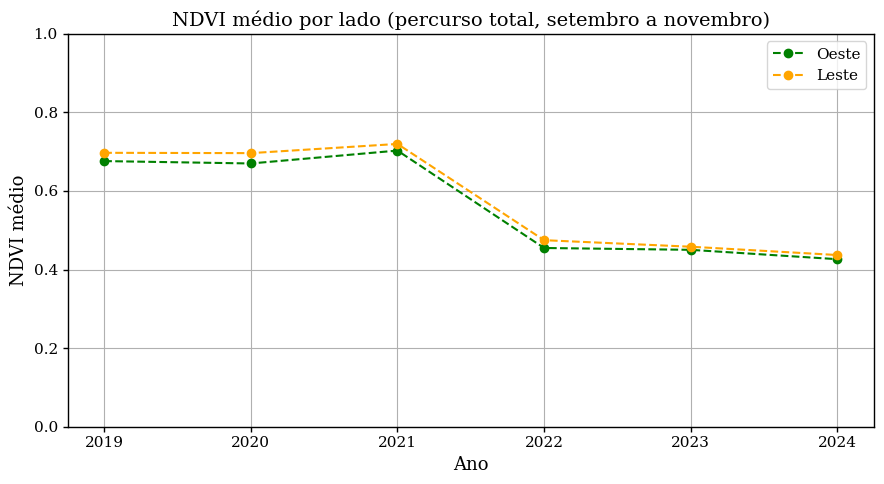

In [28]:
# -*- coding: utf-8 -*-
import ee
import matplotlib.pyplot as plt

# Inicialização
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# Assets
leste = ee.FeatureCollection("projects/ee-samuelsantosambientalcourse/assets/PA458_Leste").union(1).geometry()
oeste = ee.FeatureCollection("projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste").union(1).geometry()
anos = list(range(2019, 2025))

# Máscara S2
def mask_s2_sr(img):
    scl = img.select('SCL')
    mask = scl.neq(3).And(scl.neq(6)).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    return img.updateMask(mask)

# NDVI e filtros
def get_ndvi_image(year):
    start_month = 9
    start = ee.Date.fromYMD(year, start_month, 1)
    end = ee.Date.fromYMD(year, 11, 30)

    def add_ndvi(img):
        ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return img.addBands(ndvi)

    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate(start, end)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
           .map(mask_s2_sr)
           .map(add_ndvi)
           .select('NDVI'))
    return col.median()

# Função robusta
def zonal_mean(img, geom):
    try:
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=10,
            maxPixels=1e13
        ).get('NDVI')
        return float(val.getInfo()) if val.getInfo() is not None else None
    except:
        return None

# Processamento
ndvi_leste, ndvi_oeste = [], []

for ano in anos:
    print(f"Processando {ano}...")
    ndvi_img = get_ndvi_image(ano)
    ndvi_leste.append(zonal_mean(ndvi_img, leste))
    ndvi_oeste.append(zonal_mean(ndvi_img, oeste))

# Gráfico
plt.figure(figsize=(9, 5))
plt.plot(anos, ndvi_oeste, 'o--', label='Oeste', color='green')
plt.plot(anos, ndvi_leste, 'o--', label='Leste', color='orange')
plt.grid(True)
plt.xlabel("Ano")
plt.ylabel("NDVI médio")
plt.title("NDVI médio por lado (percurso total, setembro a novembro)")
plt.xticks(anos)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## Código para criar o gráfico de NDVI anual (primeiros 12 km)

Processando 2019...
Processando 2020...
Processando 2021...
Processando 2022...
Processando 2023...
Processando 2024...


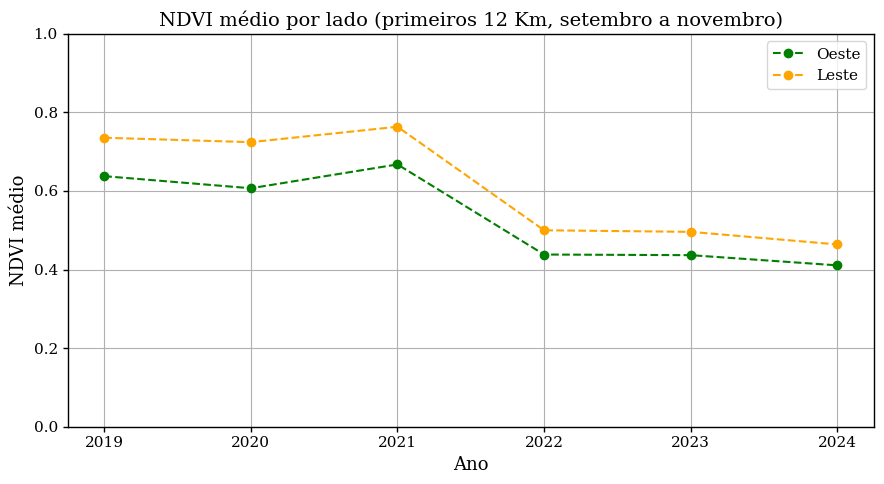

In [29]:
# -*- coding: utf-8 -*-
import ee
import matplotlib.pyplot as plt

# Inicialização
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# Assets
leste = ee.FeatureCollection("projects/ee-samuelsantosambientalcourse/assets/PA458_Leste_12km").union(1).geometry()
oeste = ee.FeatureCollection("projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste_12km").union(1).geometry()
anos = list(range(2019, 2025))

# Máscara S2
def mask_s2_sr(img):
    scl = img.select('SCL')
    mask = scl.neq(3).And(scl.neq(6)).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    return img.updateMask(mask)

# NDVI e filtros
def get_ndvi_image(year):
    start_month = 9
    start = ee.Date.fromYMD(year, start_month, 1)
    end = ee.Date.fromYMD(year, 11, 30)

    def add_ndvi(img):
        ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return img.addBands(ndvi)

    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate(start, end)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
           .map(mask_s2_sr)
           .map(add_ndvi)
           .select('NDVI'))
    return col.median()

# Função robusta
def zonal_mean(img, geom):
    try:
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=10,
            maxPixels=1e13
        ).get('NDVI')
        return float(val.getInfo()) if val.getInfo() is not None else None
    except:
        return None

# Processamento
ndvi_leste, ndvi_oeste = [], []

for ano in anos:
    print(f"Processando {ano}...")
    ndvi_img = get_ndvi_image(ano)
    ndvi_leste.append(zonal_mean(ndvi_img, leste))
    ndvi_oeste.append(zonal_mean(ndvi_img, oeste))

# Gráfico
plt.figure(figsize=(9, 5))
plt.plot(anos, ndvi_oeste, 'o--', label='Oeste', color='green')
plt.plot(anos, ndvi_leste, 'o--', label='Leste', color='orange')
plt.grid(True)
plt.xlabel("Ano")
plt.ylabel("NDVI médio")
plt.title("NDVI médio por lado (primeiros 12 Km, setembro a novembro)")
plt.xticks(anos)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## Código para gerar tabela de NDVI

Processando 2019…
Processando 2020…
Processando 2021…
Processando 2022…
Processando 2023…
Processando 2024…
CSV salvo em: outputs/tabela_ndvi_pa458_2019_2024.csv


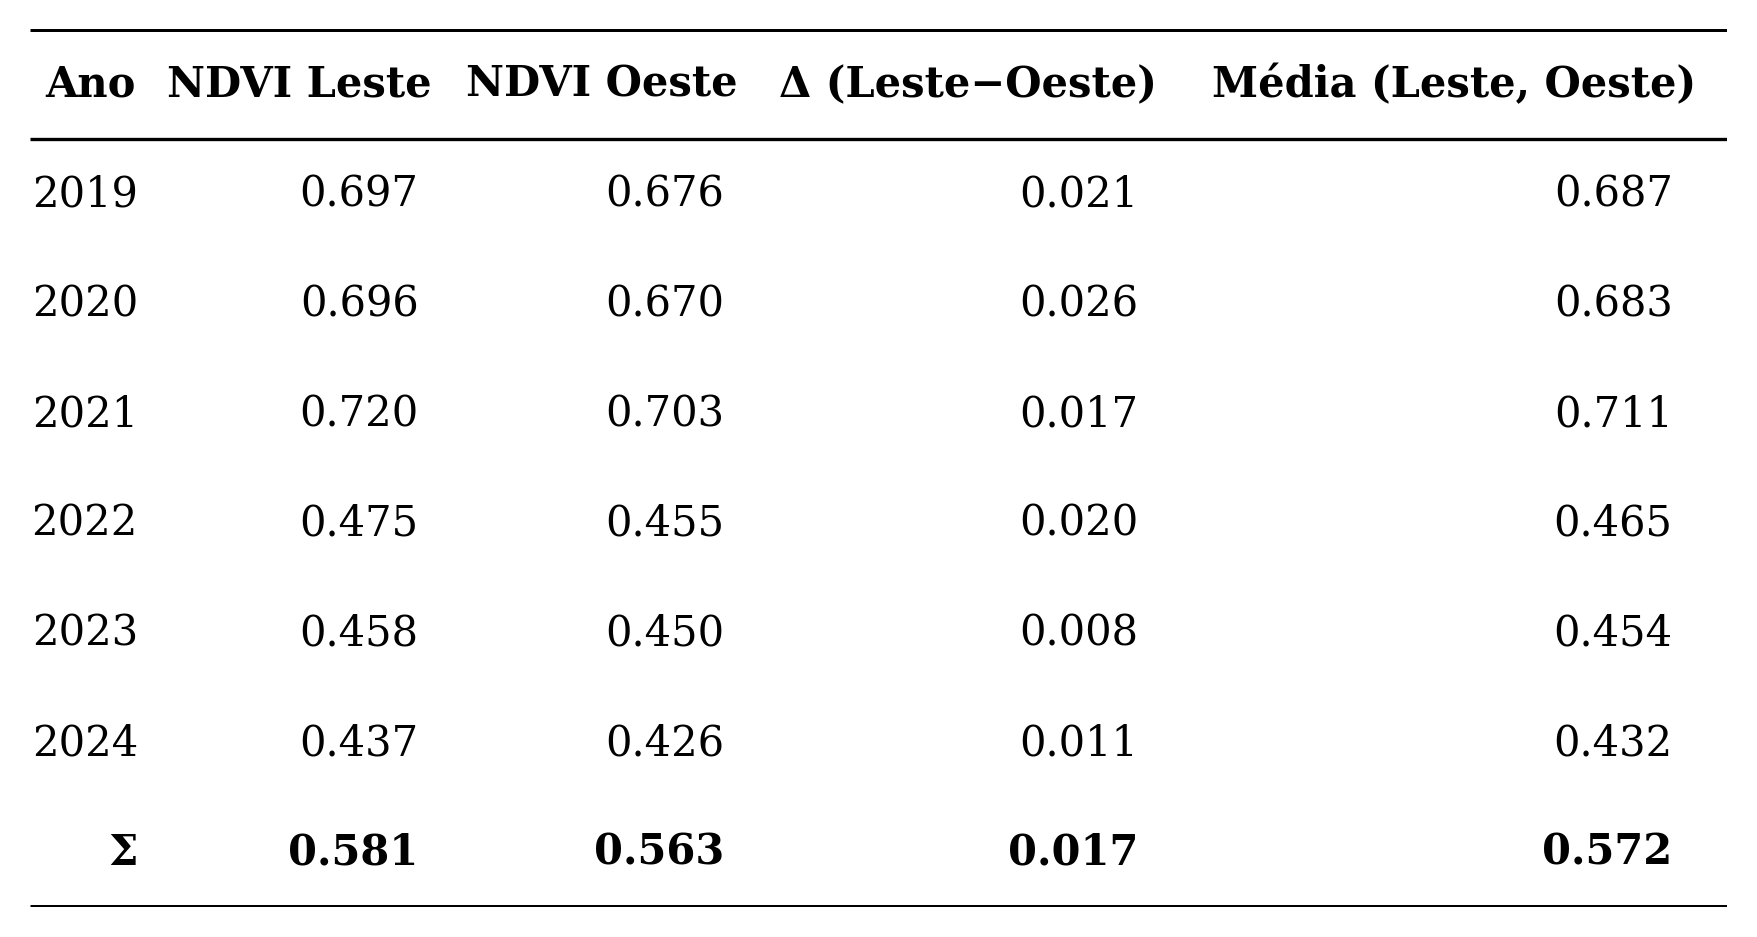

PNG (tabela) salvo em: outputs/tabela_ndvi_pa458_2019_2024.png


In [23]:
# -*- coding: utf-8 -*-
# Tabela acadêmica (imagem) — NDVI médio por lado (set–nov) PA-458 (2019–2024)
# Estilo: "booktabs-like" (top/mid/bottom rules), fonte serifada, números à direita

import os, math
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============== 1) EE Init ===============
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# =============== 2) Parâmetros ===============
ASSET_EAST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Leste"
ASSET_WEST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste"
ANOS       = list(range(2019, 2025))          # 2019–2024
MES_INI, DIA_INI = 9, 1                       # 1/set
MES_FIM, DIA_FIM = 11, 30                     # 30/nov
CLOUD_PCT  = 20
SCALE      = 10

OUT_DIR = "outputs"
CSV_PATH = os.path.join(OUT_DIR, "tabela_ndvi_pa458_2019_2024.csv")
PNG_PATH = os.path.join(OUT_DIR, "tabela_ndvi_pa458_2019_2024.png")
os.makedirs(OUT_DIR, exist_ok=True)

# =============== 3) Geometrias ===============
east_geom = ee.FeatureCollection(ASSET_EAST).union(1).geometry()
west_geom = ee.FeatureCollection(ASSET_WEST).union(1).geometry()

# =============== 4) Sentinel-2 / NDVI (set–nov) ===============
def mask_s2_sr(img: ee.Image) -> ee.Image:
    scl = img.select('SCL')
    ok = (scl.neq(3).And(scl.neq(6)).And(scl.neq(8))
          .And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11)))
    return img.updateMask(ok)

def get_ndvi_image(year: int) -> ee.Image:
    start = ee.Date.fromYMD(year, MES_INI, DIA_INI)
    end   = ee.Date.fromYMD(year, MES_FIM, DIA_FIM)
    def add_ndvi(img: ee.Image) -> ee.Image:
        return img.addBands(img.normalizedDifference(['B8','B4']).rename('NDVI'))
    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate(start, end)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
           .map(mask_s2_sr).map(add_ndvi).select('NDVI'))
    return col.median()

def zonal_mean(img: ee.Image, geom: ee.Geometry) -> float | None:
    try:
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom, scale=SCALE, maxPixels=1e13,
            tileScale=4, bestEffort=True
        ).get('NDVI')
        v = val.getInfo()
        return None if v is None else float(v)
    except Exception:
        return None

# =============== 5) Cálculo das séries ===============
dados = []
for ano in ANOS:
    print(f"Processando {ano}…")
    ndvi_img = get_ndvi_image(ano)
    leste = zonal_mean(ndvi_img, east_geom)
    oeste = zonal_mean(ndvi_img, west_geom)
    delta = None if (leste is None or oeste is None) else (leste - oeste)
    media = np.nanmean([x for x in [leste, oeste] if x is not None]) if (leste is not None or oeste is not None) else None
    dados.append({"Ano": ano, "NDVI Leste": leste, "NDVI Oeste": oeste,
                  "Δ (Leste−Oeste)": delta, "Média (Leste, Oeste)": media})

df = pd.DataFrame(dados)

# Linha Σ (média do período)
def mean_or_nan(col):
    vals = [x for x in df[col].values if (x is not None and not (isinstance(x,float) and math.isnan(x)))]
    return float(np.mean(vals)) if len(vals)>0 else np.nan

sum_row = {
    "Ano": "Σ",
    "NDVI Leste": mean_or_nan("NDVI Leste"),
    "NDVI Oeste": mean_or_nan("NDVI Oeste"),
    "Δ (Leste−Oeste)": mean_or_nan("Δ (Leste−Oeste)"),
    "Média (Leste, Oeste)": mean_or_nan("Média (Leste, Oeste)")
}
df_out = pd.concat([df, pd.DataFrame([sum_row])], ignore_index=True)

# Salva CSV “cru”
df_out.to_csv(CSV_PATH, index=False)
print(f"CSV salvo em: {CSV_PATH}")

# =============== 6) Renderização (apenas TABELA, sem título/nota) ===============
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif", "Times"],
    "font.size": 10,
})

cols = ["Ano","NDVI Leste","NDVI Oeste","Δ (Leste−Oeste)","Média (Leste, Oeste)"]

def fmt(x):
    import math
    if isinstance(x, str):
        return x
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return "–"
    return f"{x:.3f}"

display_df = df_out.copy()
for c in cols[1:]:
    display_df[c] = display_df[c].apply(fmt)

# Canvas enxuto (margens pequenas), só a tabela
fig_w, fig_h = 7.3, 3.8
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=300)
ax.axis('off')

# Tabela ocupa quase todo o canvas
table_bbox = [0.0, 0.0, 1.0, 1.0]
the_table = ax.table(
    cellText=display_df[cols].values.tolist(),
    colLabels=cols,
    cellLoc='right',
    colLoc='center',
    loc='upper left',
    bbox=table_bbox
)

# Estética “booktabs-like”: sem grades internas, só regras superior/meio/inferior
for (r, c), cell in the_table.get_celld().items():
    cell.set_edgecolor((1,1,1,0))
    cell.set_linewidth(0.0)
    cell.set_height(cell.get_height()*1.05)

n_cols = len(cols)
for c in range(n_cols):
    head = the_table[(0, c)]
    head.set_text_props(weight='bold')
    head.set_edgecolor((0,0,0,1))
    head.set_linewidth(0.0)

# Regras (linhas) manuais
x0, y0, w, h = table_bbox
top_y = y0 + h
mid_y = y0 + h - (h / (len(display_df)+1))  # sob o cabeçalho
bot_y = y0

def rule(y, lw):
    ax.plot([x0, x0+w], [y, y], transform=ax.transAxes, lw=lw, color='black', solid_capstyle='butt')

rule(top_y, 1.2)   # top rule
rule(mid_y, 0.8)   # mid rule (baixo do header)

# destaca a linha Σ (última)
last_idx = len(display_df)
for c in range(n_cols):
    the_table[(last_idx, c)].set_text_props(weight='bold')

rule(bot_y, 1.2)   # bottom rule

# Ajusta larguras
for c in range(n_cols):
    the_table.auto_set_column_width(col=c)

# Exporta e plota
plt.savefig(PNG_PATH, dpi=300, bbox_inches='tight')
plt.show()     # <-- plota na tela
plt.close(fig)

print(f"PNG (tabela) salvo em: {PNG_PATH}")


Processando 2019…
Processando 2020…
Processando 2021…
Processando 2022…
Processando 2023…
Processando 2024…
CSV salvo em: outputs/tabela_ndvi_pa458_2019_2024.csv


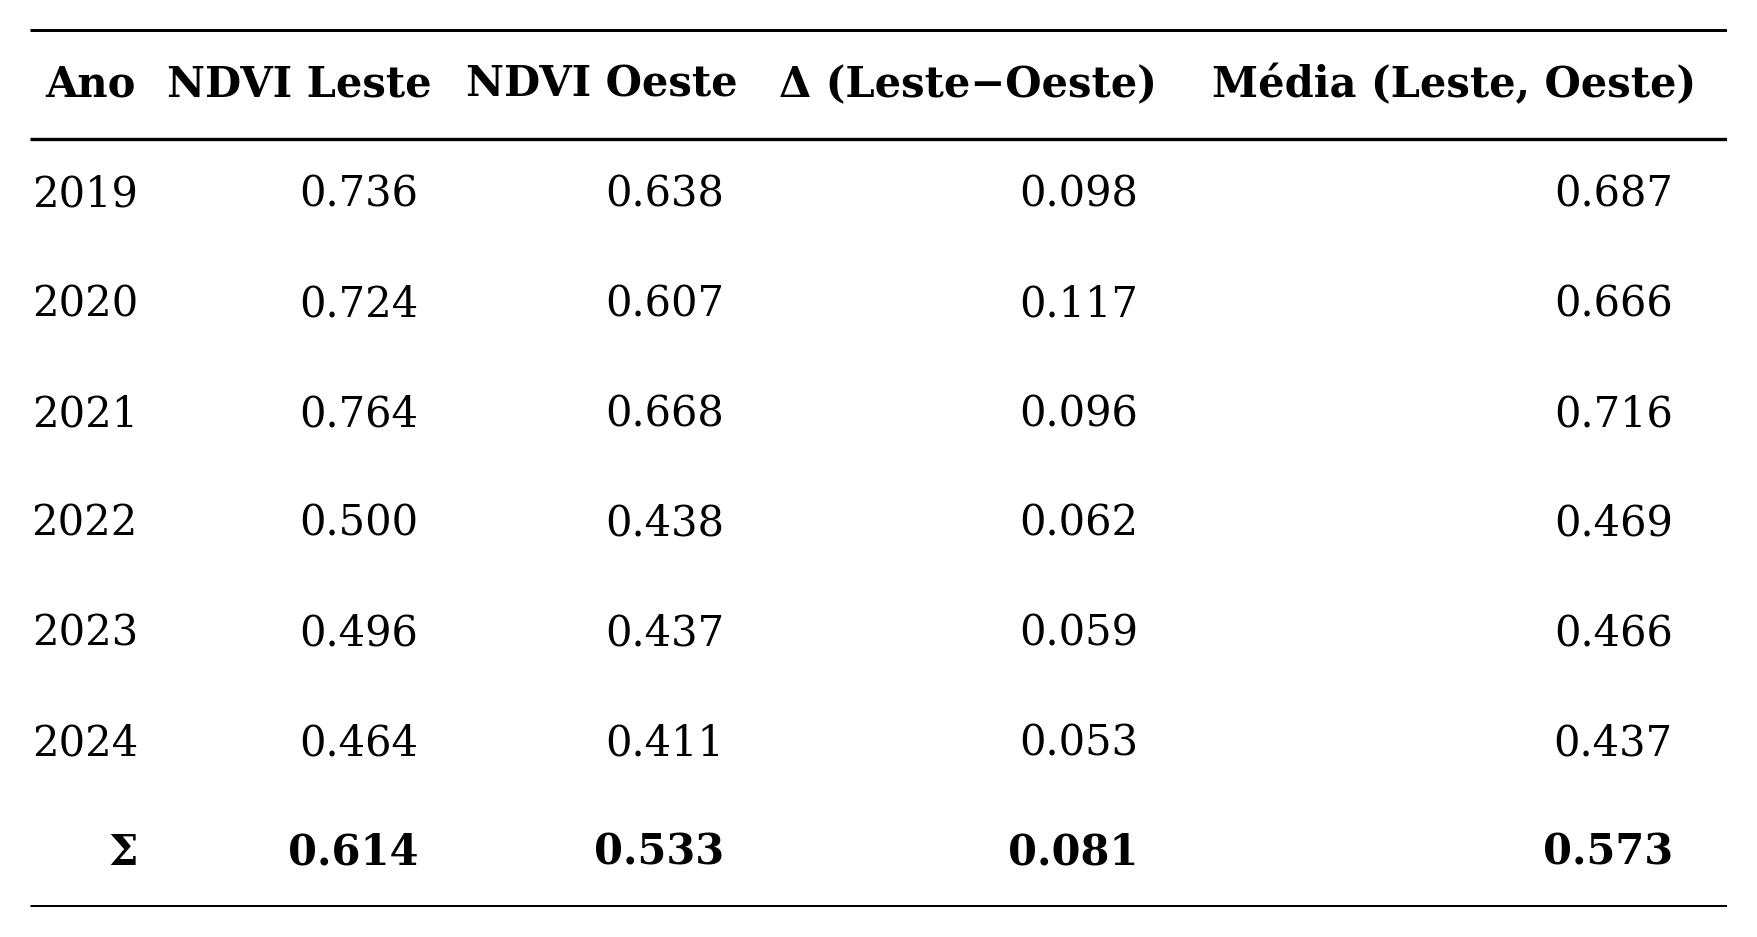

PNG (tabela) salvo em: outputs/tabela_ndvi_pa458_2019_2024.png


In [31]:
# -*- coding: utf-8 -*-
# Tabela acadêmica (imagem) — NDVI médio por lado (set–nov) PA-458 (2019–2024)
# Estilo: "booktabs-like" (top/mid/bottom rules), fonte serifada, números à direita

import os, math
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============== 1) EE Init ===============
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# =============== 2) Parâmetros ===============
ASSET_EAST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Leste_12km"
ASSET_WEST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste_12km"
ANOS       = list(range(2019, 2025))          # 2019–2024
MES_INI, DIA_INI = 9, 1                       # 1/set
MES_FIM, DIA_FIM = 11, 30                     # 30/nov
CLOUD_PCT  = 20
SCALE      = 10

OUT_DIR = "outputs"
CSV_PATH = os.path.join(OUT_DIR, "tabela_ndvi_pa458_2019_2024.csv")
PNG_PATH = os.path.join(OUT_DIR, "tabela_ndvi_pa458_2019_2024.png")
os.makedirs(OUT_DIR, exist_ok=True)

# =============== 3) Geometrias ===============
east_geom = ee.FeatureCollection(ASSET_EAST).union(1).geometry()
west_geom = ee.FeatureCollection(ASSET_WEST).union(1).geometry()

# =============== 4) Sentinel-2 / NDVI (set–nov) ===============
def mask_s2_sr(img: ee.Image) -> ee.Image:
    scl = img.select('SCL')
    ok = (scl.neq(3).And(scl.neq(6)).And(scl.neq(8))
          .And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11)))
    return img.updateMask(ok)

def get_ndvi_image(year: int) -> ee.Image:
    start = ee.Date.fromYMD(year, MES_INI, DIA_INI)
    end   = ee.Date.fromYMD(year, MES_FIM, DIA_FIM)
    def add_ndvi(img: ee.Image) -> ee.Image:
        return img.addBands(img.normalizedDifference(['B8','B4']).rename('NDVI'))
    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate(start, end)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
           .map(mask_s2_sr).map(add_ndvi).select('NDVI'))
    return col.median()

def zonal_mean(img: ee.Image, geom: ee.Geometry) -> float | None:
    try:
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom, scale=SCALE, maxPixels=1e13,
            tileScale=4, bestEffort=True
        ).get('NDVI')
        v = val.getInfo()
        return None if v is None else float(v)
    except Exception:
        return None

# =============== 5) Cálculo das séries ===============
dados = []
for ano in ANOS:
    print(f"Processando {ano}…")
    ndvi_img = get_ndvi_image(ano)
    leste = zonal_mean(ndvi_img, east_geom)
    oeste = zonal_mean(ndvi_img, west_geom)
    delta = None if (leste is None or oeste is None) else (leste - oeste)
    media = np.nanmean([x for x in [leste, oeste] if x is not None]) if (leste is not None or oeste is not None) else None
    dados.append({"Ano": ano, "NDVI Leste": leste, "NDVI Oeste": oeste,
                  "Δ (Leste−Oeste)": delta, "Média (Leste, Oeste)": media})

df = pd.DataFrame(dados)

# Linha Σ (média do período)
def mean_or_nan(col):
    vals = [x for x in df[col].values if (x is not None and not (isinstance(x,float) and math.isnan(x)))]
    return float(np.mean(vals)) if len(vals)>0 else np.nan

sum_row = {
    "Ano": "Σ",
    "NDVI Leste": mean_or_nan("NDVI Leste"),
    "NDVI Oeste": mean_or_nan("NDVI Oeste"),
    "Δ (Leste−Oeste)": mean_or_nan("Δ (Leste−Oeste)"),
    "Média (Leste, Oeste)": mean_or_nan("Média (Leste, Oeste)")
}
df_out = pd.concat([df, pd.DataFrame([sum_row])], ignore_index=True)

# Salva CSV “cru”
df_out.to_csv(CSV_PATH, index=False)
print(f"CSV salvo em: {CSV_PATH}")

# =============== 6) Renderização (apenas TABELA, sem título/nota) ===============
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif", "Times"],
    "font.size": 10,
})

cols = ["Ano","NDVI Leste","NDVI Oeste","Δ (Leste−Oeste)","Média (Leste, Oeste)"]

def fmt(x):
    import math
    if isinstance(x, str):
        return x
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return "–"
    return f"{x:.3f}"

display_df = df_out.copy()
for c in cols[1:]:
    display_df[c] = display_df[c].apply(fmt)

# Canvas enxuto (margens pequenas), só a tabela
fig_w, fig_h = 7.3, 3.8
fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=300)
ax.axis('off')

# Tabela ocupa quase todo o canvas
table_bbox = [0.0, 0.0, 1.0, 1.0]
the_table = ax.table(
    cellText=display_df[cols].values.tolist(),
    colLabels=cols,
    cellLoc='right',
    colLoc='center',
    loc='upper left',
    bbox=table_bbox
)

# Estética “booktabs-like”: sem grades internas, só regras superior/meio/inferior
for (r, c), cell in the_table.get_celld().items():
    cell.set_edgecolor((1,1,1,0))
    cell.set_linewidth(0.0)
    cell.set_height(cell.get_height()*1.05)

n_cols = len(cols)
for c in range(n_cols):
    head = the_table[(0, c)]
    head.set_text_props(weight='bold')
    head.set_edgecolor((0,0,0,1))
    head.set_linewidth(0.0)

# Regras (linhas) manuais
x0, y0, w, h = table_bbox
top_y = y0 + h
mid_y = y0 + h - (h / (len(display_df)+1))  # sob o cabeçalho
bot_y = y0

def rule(y, lw):
    ax.plot([x0, x0+w], [y, y], transform=ax.transAxes, lw=lw, color='black', solid_capstyle='butt')

rule(top_y, 1.2)   # top rule
rule(mid_y, 0.8)   # mid rule (baixo do header)

# destaca a linha Σ (última)
last_idx = len(display_df)
for c in range(n_cols):
    the_table[(last_idx, c)].set_text_props(weight='bold')

rule(bot_y, 1.2)   # bottom rule

# Ajusta larguras
for c in range(n_cols):
    the_table.auto_set_column_width(col=c)

# Exporta e plota
plt.savefig(PNG_PATH, dpi=300, bbox_inches='tight')
plt.show()     # <-- plota na tela
plt.close(fig)

print(f"PNG (tabela) salvo em: {PNG_PATH}")

## Código para criar linha temporal de precipitação mensal.

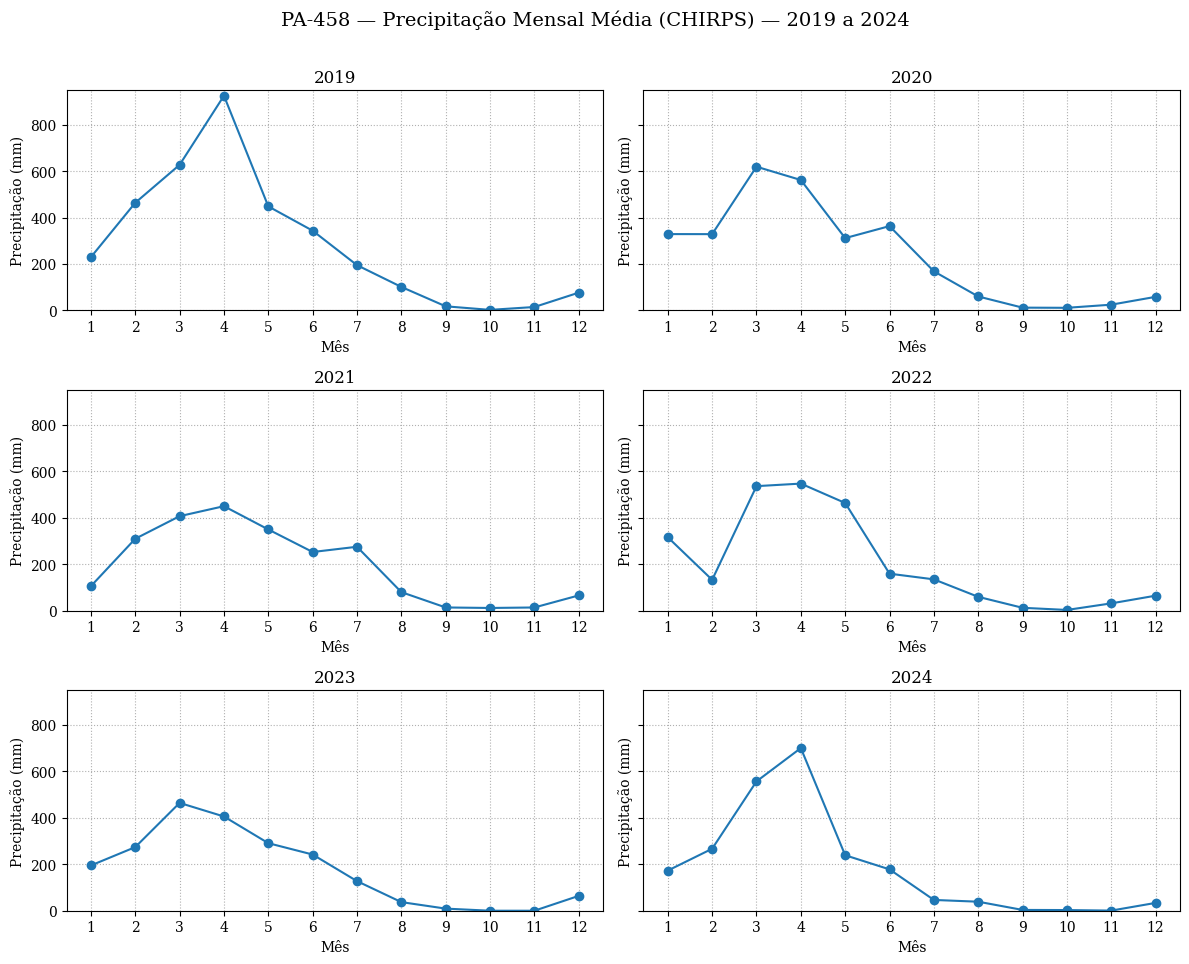

In [26]:
import ee
import numpy as np
import matplotlib.pyplot as plt

# === Inicializa o GEE ===
try:
    ee.Initialize(project='ee-samuelsantosambientalcourse')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# === Área de estudo (seu asset) ===
AOI = ee.FeatureCollection("projects/ee-samuelsantosambientalcourse/assets/PA-458")

# === Função utilitária: precipitação mensal por ano (mm) ===
def get_monthly_precipitation(fc, year:int):
    """Retorna lista de 12 valores (jan..dez) de precipitação mensal média (mm) para 'year'."""
    def by_month(m):
        m = ee.Number(m)
        ini = ee.Date.fromYMD(year, m, 1)
        end = ini.advance(1, 'month')
        img = (ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
               .filterDate(ini, end)
               .filterBounds(fc)
               .sum()                 # soma diária => total mensal (mm)
               .clip(fc))
        val = img.reduceRegion(
            reducer=ee.Reducer.mean(),  # média espacial sobre a AOI
            geometry=fc.geometry(),
            scale=5000,
            maxPixels=1e13,
            bestEffort=True
        ).get('precipitation')
        return ee.Feature(None, {'month': m, 'precip': val})

    months = ee.List.sequence(1, 12)
    fc_months = ee.FeatureCollection(months.map(by_month))
    feats = fc_months.getInfo()['features']

    out = [np.nan]*12
    for f in feats:
        m = int(f['properties']['month'])
        v = f['properties']['precip']
        out[m-1] = float(v) if v is not None else np.nan
    return out

# === Coleta séries 2019–2024 ===
years = [2019, 2020, 2021, 2022, 2023, 2024]
series = {y: get_monthly_precipitation(AOI, y) for y in years}

# === Define y-lim comum (ignora NaN) ===
all_vals = np.array([v for y in years for v in series[y]], dtype=float)
ymax = np.nanmax(all_vals)
# arredonda para cima (deixa o topo “limpo”)
ymax = float(np.ceil(ymax / 50.0) * 50.0) if np.isfinite(ymax) else None

# === Plot 3x2 ===
meses = list(range(1, 13))
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)
axes = axes.ravel()

for i, y in enumerate(years):
    ax = axes[i]
    vals = series[y]
    ax.plot(meses, vals, marker='o', linestyle='-')
    ax.set_title(f'{y}', fontsize=12)
    ax.set_xticks(meses)
    ax.set_xlabel('Mês')
    ax.grid(True, linestyle=':', linewidth=0.8)

# Rótulo comum do eixo Y e título geral
for ax in axes:
    if ymax:
        ax.set_ylim(0, ymax)
    ax.set_ylabel('Precipitação (mm)', fontsize=10)

fig.suptitle('PA-458 — Precipitação Mensal Média (CHIRPS) — 2019 a 2024', fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()


## Preparando dados para a análise bfast

In [25]:
# -*- coding: utf-8 -*-
# NDVI mensal (média zonal) por lado — robusto a meses sem dados
import ee
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelsantosambientalcourse')

# ====== Assets (12 km) ======
ASSET_EAST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Leste_12km"
ASSET_WEST = "projects/ee-samuelsantosambientalcourse/assets/PA458_Oeste_12km"
east = ee.FeatureCollection(ASSET_EAST).union(1).geometry()
west = ee.FeatureCollection(ASSET_WEST).union(1).geometry()

# ====== Janela e filtros ======
START = ee.Date('2017-01-01')
END   = ee.Date('2025-12-31')
CLOUD_PCT = 20
SCALE = 10

def mask_s2(img):
    scl = img.select('SCL')
    ok = (scl.neq(3).And(scl.neq(6)).And(scl.neq(8))
          .And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11)))
    return img.updateMask(ok)

def add_ndvi(img):
    return img.addBands(img.normalizedDifference(['B8','B4']).rename('NDVI'))

# Coleção base já com NDVI
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
      .filterDate(START, END)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
      .map(mask_s2).map(add_ndvi))

def monthly_series(geom, name):
    n_months = END.difference(START, 'month').toInt()
    months = ee.List.sequence(0, n_months.subtract(1))

    def month_feat(m):
        m = ee.Number(m)
        start = START.advance(m, 'month')
        end = start.advance(1, 'month')

        # filtra por mês e por geometria para garantir imagens relevantes
        col = (s2.filterDate(start, end)
                 .filterBounds(geom)
                 .select('NDVI'))

        # compósito mensal (pode ficar vazio se não houver pixel válido)
        comp = ee.Image(col.median()).clip(geom)

        # estatística zonal
        stats = comp.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=SCALE,
            maxPixels=1e13,
            tileScale=4,
            bestEffort=True
        )

        # se não existir chave 'NDVI', retorna null
        mean_ndvi = ee.Algorithms.If(
            stats.contains('NDVI'),
            stats.get('NDVI'),
            None  # ou ee.Number.nan()
        )

        return ee.Feature(None, {
            'date': start.format('YYYY-MM'),
            'ndvi': mean_ndvi,
            'lado': name
        })

    return ee.FeatureCollection(months.map(month_feat))

fc_e = monthly_series(east, 'Leste')
fc_w = monthly_series(west, 'Oeste')
fc = fc_e.merge(fc_w)

task = ee.batch.Export.table.toDrive(
    collection=fc,
    description='PA458_NDVI_mensal_Leste_Oeste_2017_2025_12km',
    folder='PA458_ByPolygons',
    fileNamePrefix='PA458_NDVI_mensal_2017_2025_12km',
    fileFormat='CSV'
)
task.start()
print("Export iniciado: verifique as Tasks no EE")


Export iniciado: verifique as Tasks no EE
